### 1. Основные библиотеки

In [1]:
import numpy as np
import pandas as pd
import pickle # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 2. Разделение датасета

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

### 3. Модели

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

### 4. Метрики качества

In [4]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

### 5. Для визуализации внешних картинок в ноутбуке

In [5]:
from IPython.display import Image

In [6]:
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

### Пути к директория и файлам

In [7]:
DATASET_PATH = './datasets/housing/housing.csv'
PREPARED_DATASET_PATH = './datasets/housing/housing_prepared.csv'
REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

## 1). ~ Загрузка данных

### 1. Уменьшаем размер датасета reduce_mem_usage 

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2.83 MB
Memory usage after optimization is: 1.06 MB
Decreased by 62.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_rooms
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,14.659091,0.365909,0,0,0,1,0,2083.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,15.579659,0.338217,0,0,0,1,0,2083.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,12.951602,0.338105,0,0,0,1,0,2083.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,18.445839,0.437991,0,0,0,1,0,2083.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,17.209589,0.347265,0,0,0,1,0,2083.0


In [10]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
bedroom_share           float32
population_per_room     float32
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
median_rooms            float32
dtype: object

#### Проверка на пропуски

In [11]:
df.isnull().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
bedroom_share          0
population_per_room    0
<1H OCEAN              0
INLAND                 0
ISLAND                 0
NEAR BAY               0
NEAR OCEAN             0
median_rooms           0
dtype: int64

### 2) ~ EDA и очистка данных

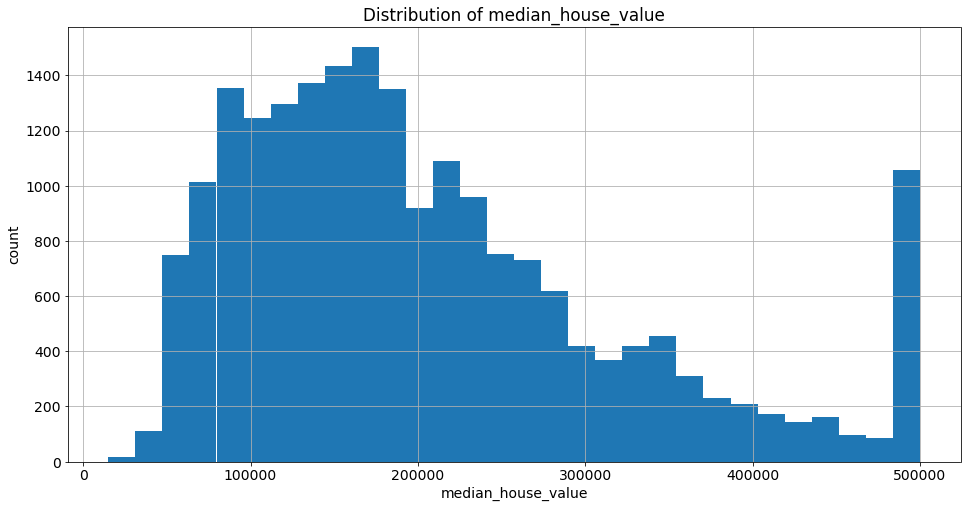

In [12]:
plt.figure(figsize=(16, 8))

df['median_house_value'].hist(bins=30)

plt.xlabel('median_house_value')
plt.ylabel('count')

plt.title('Distribution of median_house_value')

plt.show()

In [13]:
df = df[df['median_house_value'] <= 500000].reset_index()

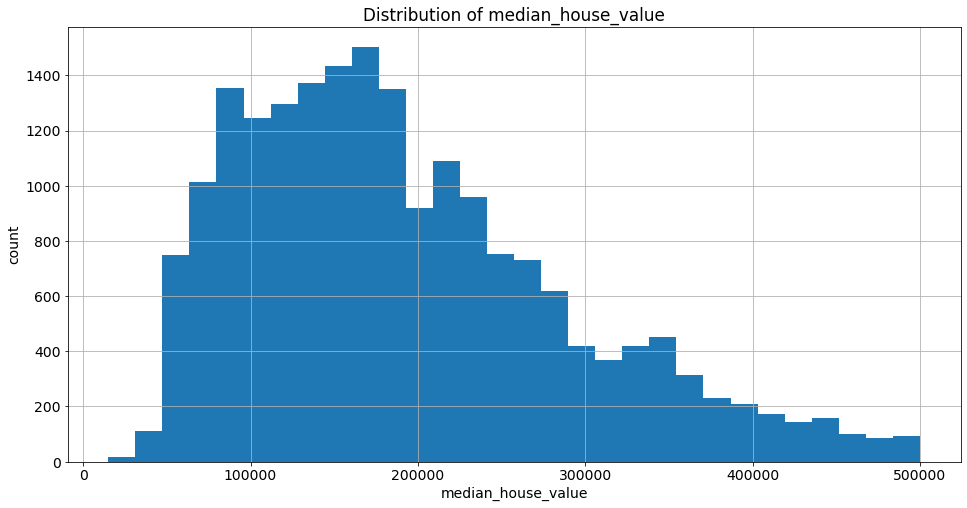

In [14]:
plt.figure(figsize=(16, 8))

df['median_house_value'].hist(bins=30)

plt.xlabel('median_house_value')
plt.ylabel('count')

plt.title('Distribution of median_house_value')

plt.show()

### 3) ~ Очистка данных и Feature Enginering

In [15]:
# Шаблон-класс DataPipeline

class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        pass
    
    def fit(self, df):
        """Сохранение статистик"""
        pass
        
    def transform(self, df):
        """Трасформация данных"""
        pass

#### Оставим признаки, которые необходимы для модели

In [16]:
df.columns.tolist()  # .tolist() преобразует колонки в список

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'bedroom_share',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_rooms']

In [17]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [18]:
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


#### Стандартизация признаков

In [19]:
feature_names_for_stand = df[feature_names].select_dtypes('float32', 'float16').columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [20]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) --> [0, 1]
# StandardScaler() Для каждой фичи x делает: (x - mean) / std   --> mean = 0, std = 1
# RobustScaler() Этот масштабатор удаляет медиану и масштабирует данные в соответствии c ...

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])
stand_features

array([[-1.3296409 ,  1.0366442 ,  1.0243417 , ..., -0.98255783,
        -0.9789465 ,  2.9603806 ],
       [-1.3246547 ,  1.0273402 , -0.6042318 , ...,  0.856557  ,
         1.6615938 ,  2.9452236 ],
       [-1.3346232 ,  1.0226873 ,  1.920057  , ..., -0.8286348 ,
        -0.8458758 ,  2.2803533 ],
       ...,
       [ 0.6195371 , -1.0799824 ,  1.920057  , ..., -0.618981  ,
        -0.5562513 , -0.18221322],
       [ 0.6195371 , -1.0753312 ,  1.920057  , ..., -0.96575016,
        -0.8902327 , -0.5990307 ],
       [ 0.53977364, -1.0334638 ,  0.04719759, ..., -0.8940963 ,
        -0.8563127 , -0.6830311 ]], dtype=float32)

In [21]:
stand_features.shape

(19675, 8)

In [22]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.329641,1.036644,1.024342,-0.797584,-0.974311,-0.982558,-0.978947,2.960381,0,0,1,0,452600.0
1,-1.324655,1.027340,-0.604232,2.053478,1.349771,0.856557,1.661594,2.945224,0,0,1,0,358500.0
2,-1.334623,1.022687,1.920057,-0.528477,-0.829205,-0.828635,-0.845876,2.280353,0,0,1,0,352100.0
3,-1.339609,1.022687,1.920057,-0.616957,-0.722159,-0.773789,-0.736288,1.252288,0,0,1,0,341300.0
4,-1.339609,1.022687,1.920057,-0.455126,-0.615113,-0.767596,-0.631919,0.107935,0,0,1,0,342200.0


#### Сохранение датасета

In [23]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

### 4) ~ Разбиение на train / test

In [24]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)  # shuffle=True при желании

### 5) ~ Построение моделей

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

$$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [25]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print(f'R2:\t{round(r2(true_values, pred_values), 3)}')
    print(f'RMSE:\t{round(np.sqrt(mse(true_values, pred_values)), 3)}')
    print(f'MSE:\t{round(mse(true_values, pred_values), 3)}')
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black') # график диагонали true_value == pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    
    plt.show()

### 5.1) ~ LinearRegression

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

Находим производные по параметрам и решим систему из 3 уравнений с 3 неизвестными:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$  

In [26]:
# np.clip([-10, 1, 100000, 1000000], a_min=10000, a_max=500000)

R2:	0.612
RMSE:	60526.389
MSE:	3663443778.016


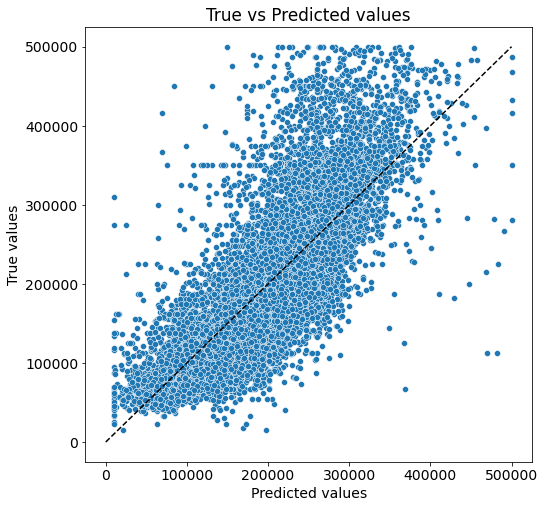

In [27]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.609
RMSE:	61780.778
MSE:	3816864551.628


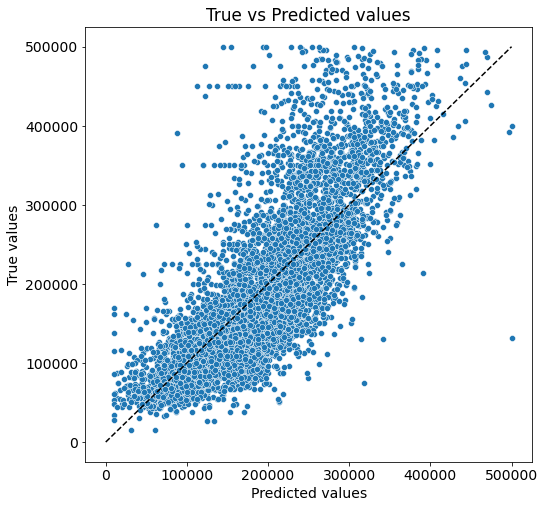

In [28]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)
evaluate_preds(y_test, y_test_preds)

### 5.2) ~ Decision tree

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

R2:	1.0
RMSE:	0.0
MSE:	0.0


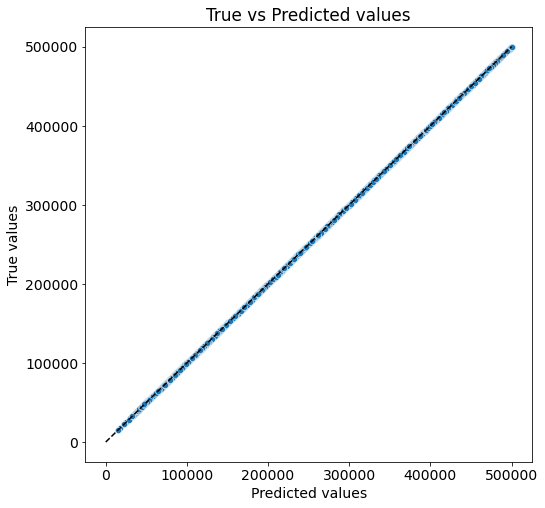

In [29]:
# пример переобученной модели train и test совершенно различны

dt_model = DecisionTreeRegressor(
    criterion='mse',
    max_depth=400,  # глубина дерева
    min_samples_leaf=1,  # минимальное количество наблюдений в листе дерева
    random_state=42
)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.571
RMSE:	64777.37
MSE:	4196107658.833


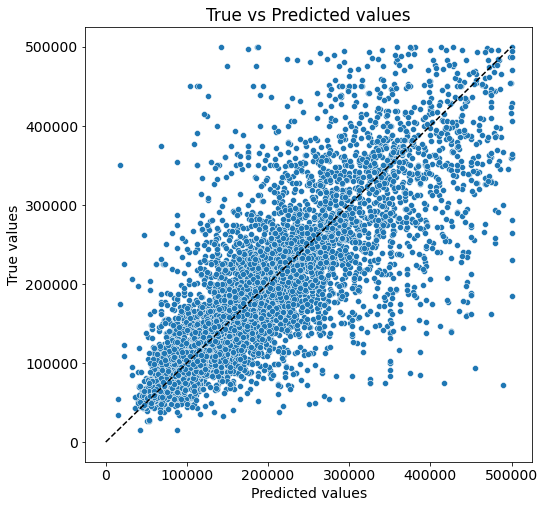

In [30]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [31]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

In [32]:
# plt.figure(figsize=(20, 10))
# plot_tree(dt_model, feature_names=X_train.columns, filled = True)
# plt.show()

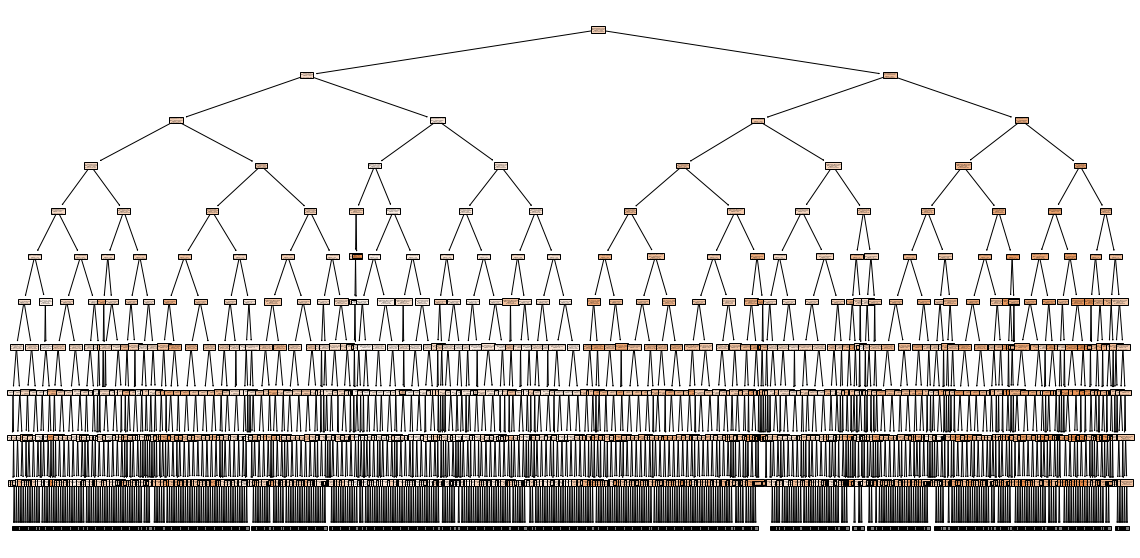

In [37]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, max_depth=10)
plt.show()

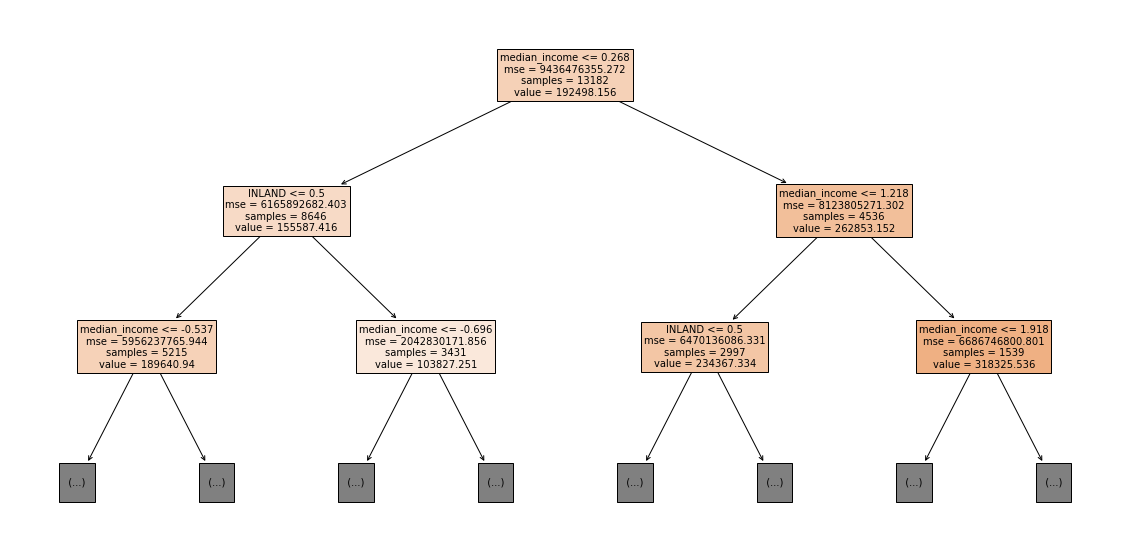

In [34]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, max_depth=2)
plt.show()

### 5.3) ~ Random Forest

**Независимо** строятся N деревьев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

Бутстрэп - выбираем из обучающей выборки k объектов с возвращением.<br>
Бэггинг - Бутстрэп-агрегирование<br>
Про бэггинг и бутстрэп можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/)

R2:	0.768
RMSE:	46766.143
MSE:	2187072157.053


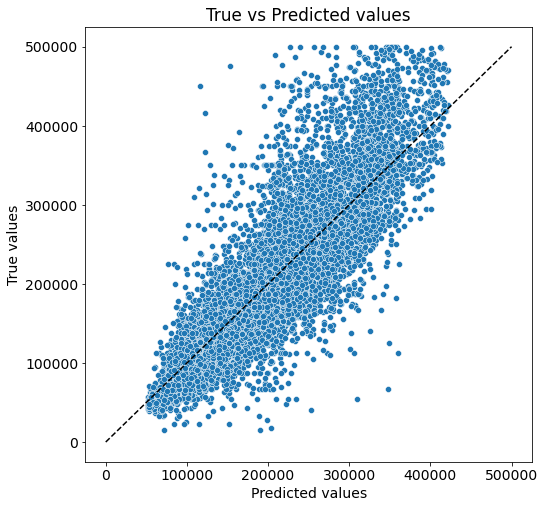

In [35]:
rf_model = RandomForestRegressor(
    criterion='mse',
    max_depth=20,  # глубина дерева
    min_samples_leaf=30,  # минимальное количество наблюдений в листе дерева
    random_state=42,
    n_estimators=100  # количество деревьев
)

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.722
RMSE:	52092.276
MSE:	2713605185.385


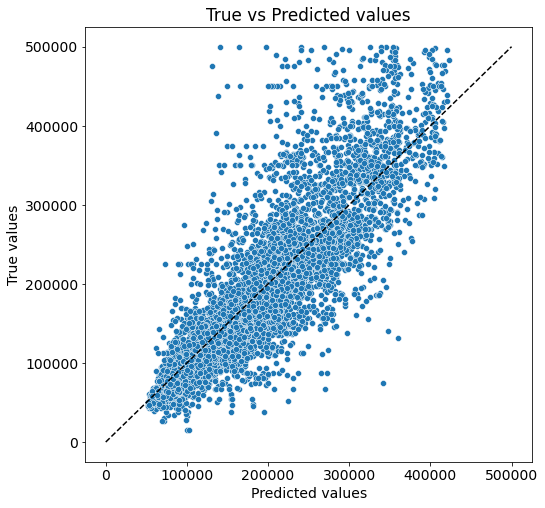

In [36]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4) ~ Gradient Boosting decision trees

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

In [38]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [39]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [42]:
# Второе дерево: target = ошибка первого дерева (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [44]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [47]:
# Третье дерево: target = ошибка второго дерева (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_3 = y_3 - y_pred_3
error_3

array([ 1,  0, -1, -3,  3])

In [48]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

R2:	0.897
RMSE:	31148.463
MSE:	970226732.155


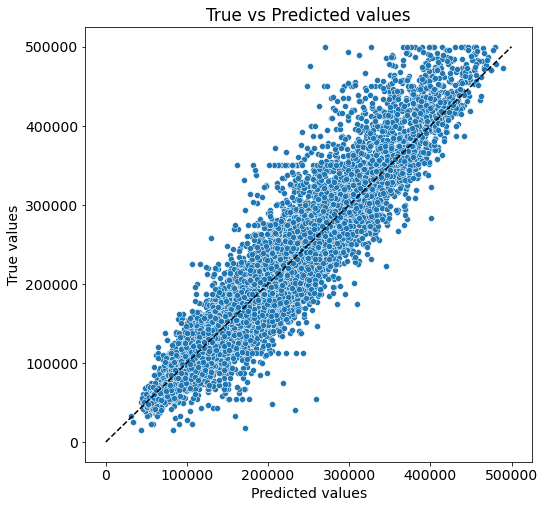

In [52]:
gb_model = GradientBoostingRegressor(
    criterion='mse',
    max_depth=7,
    min_samples_leaf=10,
    random_state=42,
    n_estimators=100
)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.799
RMSE:	44361.13
MSE:	1967909853.373


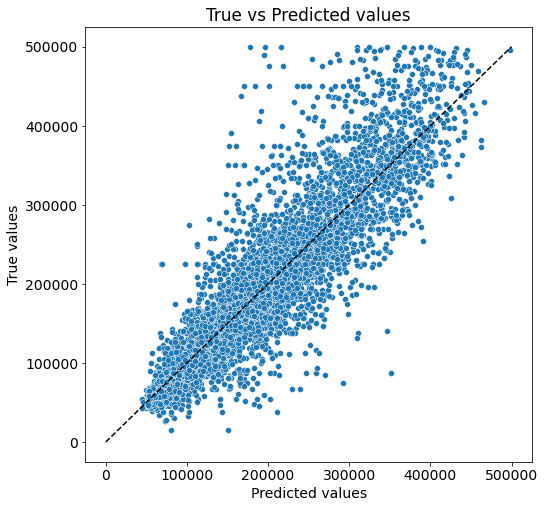

In [53]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)